In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext rpy2.ipython

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.io as sio
import scipy.sparse as sps

from ampute import ampute_mcar, ampute_mar
from coclust_mod_impute import (CoclustModImpute,
                                summarize_blocks, get_block_counts,
                                _impute_block_representative, _impute_block_ca)
from utils import show_matrix
import joblib
import os # to play sound at the end of the execution

In [3]:
np.set_printoptions(precision=3)

In [4]:
%%R
library(missMDA)
library(FactoMineR)

In [5]:
X = np.array([
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]])
X = X[np.ix_([0, 2, 7, 1, 4, 8, 3, 5, 6],
             [ 0,  4,  5, 15,  8,  9, 12, 13,  7, 10,  1,  2,  3,  6, 11, 14])]

n_clusters = 3
w = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2])
z = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])

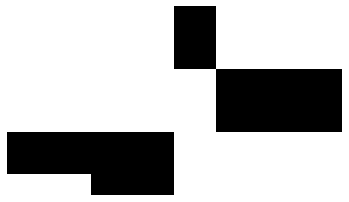

In [6]:
show_matrix(X)

In [7]:
res, r_nan, c_nan = ampute_mcar(X, .2)
print(np.isnan(res).sum())
print(res)

28
[[ 0.  0.  0.  0. nan  0.  0.  0.  1. nan  0. nan nan  0.  0.  0.]
 [ 0.  0. nan nan  0.  0.  0.  0.  1.  1.  0. nan  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0. nan  0.  0.]
 [ 0.  0.  0. nan  0.  0.  0. nan nan  0.  1.  1.  1.  1.  1.  1.]
 [nan nan nan  0.  0. nan  0.  0.  0. nan  1.  1.  1.  1. nan  1.]
 [ 0.  0. nan  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1. nan  1.]
 [ 1. nan  1.  1. nan  1.  1.  1.  0.  0.  0.  0.  0.  0. nan  0.]
 [ 1. nan  1.  1.  1. nan  1. nan  0.  0.  0.  0.  0. nan  0.  0.]
 [ 0.  0.  0.  0. nan nan  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [8]:
z_labels = np.arange(n_clusters)[:, np.newaxis]
w_labels = z_labels

Z = (z == z_labels).T
W = (w == w_labels).T

In [9]:
summarize_blocks(X, Z, W)

array([[ 0,  6,  0],
       [ 0,  0, 18],
       [20,  0,  0]])

In [10]:
get_block_counts(Z, W)

array([[24,  6, 18],
       [24,  6, 18],
       [24,  6, 18]])

In [11]:
Z.shape, W.shape

((9, 3), (16, 3))

In [12]:
block_rep_vals = summarize_blocks(X, Z, W) / get_block_counts(Z, W)
block_rep_vals

array([[0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   ],
       [0.833, 0.   , 0.   ]])

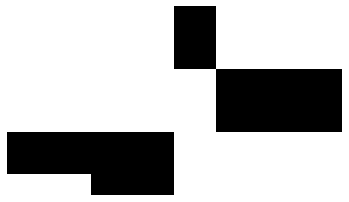

In [13]:
tmp = res.copy()
tmp[r_nan, c_nan] = block_rep_vals[z[r_nan],w[c_nan]]
show_matrix(tmp)

In [14]:
print(np.round(tmp[r_nan, c_nan],2))
print(X[r_nan, c_nan])

[0.83 0.   0.   0.83 0.   0.   0.83 0.   0.   0.   0.   1.   1.   0.83
 0.83 0.   0.   0.   0.   0.   0.   0.83 0.   0.83 0.   0.   1.   0.  ]
[1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0]


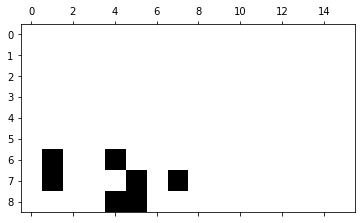

In [15]:
show_matrix(np.abs(X-tmp), no_axes=False)

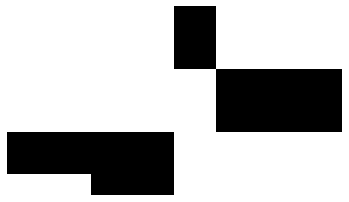

In [16]:
XW = X @ W
# cls = np.argmax(XW, axis=1)
# Z = cls == z_labels
# print(XW)

na_rep = XW / W.sum(axis=0)
# print(np.round(na_rep,5))
X_nan = res.copy()
X_nan[r_nan, c_nan] = (na_rep @ W.T)[r_nan, c_nan]

show_matrix(X_nan)

# print(np.round(W.T @ na_rep,2).T[nan_mask])



In [17]:
print(np.round(X_nan[r_nan, c_nan],2))
print(X[r_nan, c_nan])

[1.  0.  0.  1.  0.  0.  0.5 0.  0.  0.  0.  1.  1.  0.5 1.  0.  0.  0.
 0.  0.  0.  1.  0.  1.  0.  0.  1.  0. ]
[1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0]


SSE: 0.5
rounded error matrix


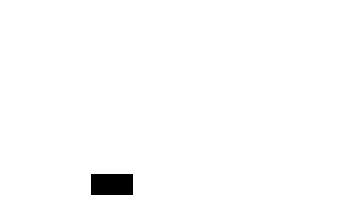

In [18]:
diff = np.abs(X-X_nan)
print(f"SSE: {(diff**2).sum()}")
print("rounded error matrix")
show_matrix(diff)

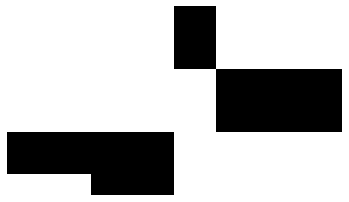

In [19]:
XtZ = X.T @ Z

na_rep = XtZ / Z.sum(axis=0)
# print(np.round(na_rep,5))
X_nan = res.copy()
X_nan[r_nan, c_nan] = (Z @ na_rep.T)[r_nan, c_nan]

show_matrix(X_nan)

In [20]:
print(np.round(X_nan[r_nan, c_nan],2))
print(X[r_nan, c_nan])

[1.   0.   0.   0.67 0.   0.   1.   0.   0.   0.   0.   1.   1.   1.
 1.   0.   0.   0.   0.   0.   0.   1.   0.   0.67 0.   0.   1.   0.  ]
[1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0]


SSE: 0.22222222222222227
rounded error matrix


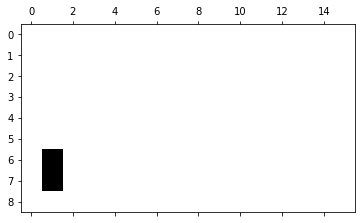

In [21]:
diff = np.abs(X-X_nan)
print(f"SSE: {(diff**2).sum()}")
print("rounded error matrix")
show_matrix(diff, no_axes=False)

## Modification de CoClustMod

In [22]:
X_missing, r_nan, c_nan = ampute_mar(X, .2, random_state=None)

Percentage of newly generated mising values: 0.2013888888888889


In [23]:
%%R -i X_missing -o ca_imputed
ca_imputed <- imputeCA(X_missing, ncp=2)

In [24]:
init_vals = ca_imputed[r_nan, c_nan]

In [25]:
model = CoclustModImpute(n_clusters=3)
print(X_missing)

[[ 0. nan nan nan nan  0.  0.  0.  1.  1.  0.  0. nan  0.  0.  0.]
 [ 0. nan nan  0.  0.  0.  0.  0.  1.  1.  0.  0. nan  0.  0.  0.]
 [ 0. nan nan nan  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. nan nan  0.  0.  0.  0.  1.  1.  1.  1.  1. nan]
 [ 0.  0. nan nan nan nan  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0. nan nan nan  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0. nan  0. nan  0.]
 [nan  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0. nan  0.]
 [nan  0.  0.  0.  1.  1. nan  1.  0.  0.  0.  0. nan  0. nan  0.]]


In [26]:
model.fit(X_missing, _impute_block_representative, initial_vals=init_vals)
# model.fit(X_missing, _impute_block_representative, initial_vals=None)

CoclustModImpute(init=None, max_iter=20, n_clusters=3, n_init=1, n_jobs=1,
                 random_state=None, tol=1e-09)

SSE: 9.115214121383913
rounded error matrix


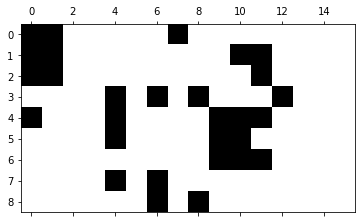

In [27]:
diff = np.abs(X-model.X_)
print(f"SSE: {(diff**2).sum()}")
print("rounded error matrix")
show_matrix(diff[np.ix_(np.argsort(model.row_labels_), np.argsort(model.column_labels_))], no_axes=False)

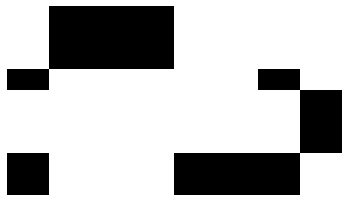

In [28]:
show_matrix(X[np.ix_(np.argsort(model.row_labels_), np.argsort(model.column_labels_))])

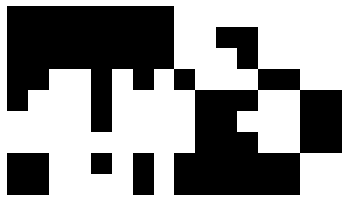

In [29]:
show_matrix(model.X_[np.ix_(np.argsort(model.row_labels_), np.argsort(model.column_labels_))])

## Test on real dataset

In [30]:
dataset_names = ['RCV1', 'WebACE', 'classic3', 'classic4', 'cstr', 'ng20', 'reviews', 'sports']
for dname in dataset_names:
    m = sio.loadmat(f'data/{dname}.mat')
    print(f'{dname!r}: ', [*filter(lambda x: not x.startswith('__'),[*m])])

'RCV1':  ['ans', 'gnd', 'fea', 'm', 'n', 'I', 'j', 'nz', 'i', 'x', 'X1', 'sumX']
'WebACE':  ['gnd', 'fea']
'classic3':  ['A', 'ts', 'ms', 'labels', 'cK']
'classic4':  ['labels', 'mat', 'fea']
'cstr':  ['gnd', 'fea']
'ng20':  ['labels', 'mat', 'fea']
'reviews':  ['dtm', 'classid']
'sports':  ['dtm', 'classid']


In [31]:
keys = {
    'cstr':  ['gnd', 'fea'],
    'WebACE':  ['gnd', 'fea'],
    'classic3':  ['labels', 'A'],
    'classic4':  ['labels', 'mat'],
#     'reviews':  ['classid', 'dtm'],
#     'sports':  ['classid', 'dtm'],
#     'RCV1':  ['gnd', 'fea'],
#     'ng20':  ['labels', 'mat'],
}

In [32]:
na_props = [.1, .2, .5, .7]

In [33]:
dataset = 'cstr'
na_prop = 0.1
ampute_method = 'mcar'
init_method = 'CA'
impute_init = init_method

In [34]:
mat = sio.loadmat(f'data/{dataset}.mat')

In [35]:
X = mat[keys[dataset][1]]
y = mat[keys[dataset][0]]
X.shape

(475, 1000)

In [36]:
if isinstance(X, sps.csr_matrix) or isinstance(X, sps.csc_matrix):
    X = X.toarray()
n_clusters = len(np.unique(y.ravel()))
n_clusters

4

In [37]:
type(X)

numpy.ndarray

In [38]:
if ampute_method == 'mcar':
    X_missing, r_nan, c_nan = ampute_mcar(X, na_prop)
elif ampute_method == 'mar':
    X_missing, r_nan, c_nan = ampute_mar(X, na_prop)

In [39]:
# m = joblib.load(f'data/missMDA_imputed/{dataset}_{int(na_prop*100)}__{ampute_method}.joblib')

In [40]:
# %%R -i X_missing -o ca_imputed
# ca_imputed <- imputeCA(X_missing, ncp=2)

In [41]:
# init_vals = ca_imputed[r_nan, c_nan]

In [42]:
model = CoclustModImpute(n_clusters=n_clusters, n_init=10, n_jobs=2)
if init_method == 'CA':
    m = joblib.load(f'data/missMDA_imputed/{dataset}_{int(na_prop*100)}__{ampute_method}.joblib')
    model.fit(X_missing, _impute_block_representative, initial_vals=m['imputed'])
else:
    model.fit(X_missing, _impute_block_representative, initial_vals=impute_init)

CoclustModImpute(init=None, max_iter=20, n_clusters=4, n_init=10, n_jobs=2,
                 random_state=None, tol=1e-09)

RMSE: 31.26362133794324
rounded error matrix


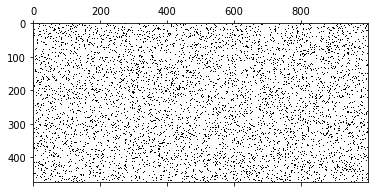

In [44]:
diff = np.abs(X-model.X_)
print(f"RMSE: {((diff**2).sum()/r_nan.shape[0])**.5}")
print("rounded error matrix")
show_matrix(diff[np.ix_(np.argsort(model.row_labels_), np.argsort(model.column_labels_))], no_axes=False)

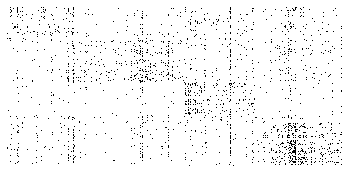

In [45]:
show_matrix(X[np.ix_(np.argsort(model.row_labels_), np.argsort(model.column_labels_))])

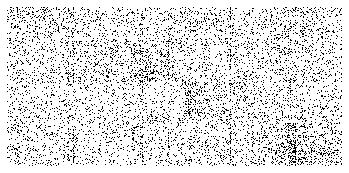

In [46]:
show_matrix(model.X_[np.ix_(np.argsort(model.row_labels_), np.argsort(model.column_labels_))])

In [47]:
# sio.savemat(f'data/out/{dataset}-{ampute_method}-{na_prop}-{init_method}.mat', {
#     'imputed': model.X_[r_nan, c_nan],
#     'r_nan': r_nan,
#     'c_nan': c_nan,
#     'z': model.row_labels_,
#     'w': model.column_labels_,
# })

In [48]:
# joblib.dump({
#     'imputed': model.X_[r_nan, c_nan],
#     'real': X[r_nan, c_nan],
#     'r_nan': r_nan,
#     'c_nan': c_nan,
#     'z': model.row_labels_,
#     'w': model.column_labels_,
# }, f'data/out/{dataset}-{ampute_method}-{na_prop}-{init_method}.joblib', compress=3)

In [49]:
# ! play --no-show-progress --null --channels 1 synth 1 sine 440
# os.system('echo -e "\07" && echo -e "\007"')

In [51]:
impute_fn = _impute_block_ca
impute_params={'ncp':2}

In [ ]:
for init_method in ['CA', 'zero', 'rand']:
    for ampute_method in ('mar','mcar'):
        print("#"*15, ampute_method, "#"*15)
        for dataset in keys:
            print("*"*10, dataset, "*"*10)
            mat = sio.loadmat(f'data/{dataset}.mat')
            X = mat[keys[dataset][1]]
            y = mat[keys[dataset][0]]
            if isinstance(X, sps.csr_matrix) or isinstance(X, sps.csc_matrix):
                X = X.toarray()
            if isinstance(y, sps.csr_matrix) or isinstance(y, sps.csc_matrix):
                y = y.toarray()
            n_clusters = len(np.unique(y.ravel()))

            for na_prop in na_props:
                print("-"*5, na_prop, "-"*5)
                save_path = f'data/out/coclustmod_impute_ca-{dataset}-{ampute_method}-{na_prop}-{init_method}.joblib'
                if os.path.exists(save_path):
                    print('already computed')
                    continue
    #             print('stopping')
    #             break
                if ampute_method == 'mcar':
                    X_missing, r_nan, c_nan = ampute_mcar(X, na_prop)
                elif ampute_method == 'mar':
                    obj = joblib.load(f'data/out/nan_idx-{dataset}-mar-{na_prop}.joblib')
                    r_nan, c_nan = obj['r_nan'], obj['c_nan']
                    X_missing = X.astype(float)
                    X_missing[r_nan, c_nan] = np.nan
    #                 X_missing, r_nan, c_nan = ampute_mar(X, na_prop)

                model = CoclustModImpute(n_clusters=n_clusters, n_init=10, n_jobs=2)
                if init_method == 'CA':
                    m = joblib.load(f'data/missMDA_imputed/{dataset}_{int(na_prop*100)}__{ampute_method}.joblib')
                    model.fit(X_missing, impute_fn, impute_params, initial_vals=m['imputed'])
                else:
                    model.fit(X_missing, impute_fn, impute_params, initial_vals=impute_init)

                diff = np.abs(X-model.X_)
                print(f"RMSE: {((diff**2).sum()/r_nan.shape[0])**.5}")

                joblib.dump({
                    'imputed': model.X_[r_nan, c_nan],
                    'real': X[r_nan, c_nan],
                    'r_nan': r_nan,
                    'c_nan': c_nan,
                    'z': model.row_labels_,
                    'w': model.column_labels_,
                }, save_path, compress=3)
    
os.system('echo -e "\07" && echo -e "\007"')

############### mar ###############
********** cstr **********
----- 0.1 -----
already computed
----- 0.2 -----
already computed
----- 0.5 -----
already computed
----- 0.7 -----
already computed
********** WebACE **********
----- 0.1 -----


CoclustModImpute(init=None, max_iter=20, n_clusters=20, n_init=10, n_jobs=2,
                 random_state=None, tol=1e-09)

RMSE: 437.88432270301536


['data/out/coclustmod_impute_ca-WebACE-mar-0.1-CA.joblib']

----- 0.2 -----


CoclustModImpute(init=None, max_iter=20, n_clusters=20, n_init=10, n_jobs=2,
                 random_state=None, tol=1e-09)

RMSE: 2583.201907154537


['data/out/coclustmod_impute_ca-WebACE-mar-0.2-CA.joblib']

----- 0.5 -----


CoclustModImpute(init=None, max_iter=20, n_clusters=20, n_init=10, n_jobs=2,
                 random_state=None, tol=1e-09)

RMSE: 760.9880202545952


['data/out/coclustmod_impute_ca-WebACE-mar-0.5-CA.joblib']

----- 0.7 -----


CoclustModImpute(init=None, max_iter=20, n_clusters=20, n_init=10, n_jobs=2,
                 random_state=None, tol=1e-09)

RMSE: 102340.2267293851


['data/out/coclustmod_impute_ca-WebACE-mar-0.7-CA.joblib']

********** classic3 **********
----- 0.1 -----


CoclustModImpute(init=None, max_iter=20, n_clusters=3, n_init=10, n_jobs=2,
                 random_state=None, tol=1e-09)

RMSE: 0.2176207991413755


['data/out/coclustmod_impute_ca-classic3-mar-0.1-CA.joblib']

----- 0.2 -----


CoclustModImpute(init=None, max_iter=20, n_clusters=3, n_init=10, n_jobs=2,
                 random_state=None, tol=1e-09)

RMSE: 0.20085508971602636


['data/out/coclustmod_impute_ca-classic3-mar-0.2-CA.joblib']

----- 0.5 -----


CoclustModImpute(init=None, max_iter=20, n_clusters=3, n_init=10, n_jobs=2,
                 random_state=None, tol=1e-09)

RMSE: 0.18039055209313176


['data/out/coclustmod_impute_ca-classic3-mar-0.5-CA.joblib']

----- 0.7 -----
